
=== LOAD curve + swaptions template ===


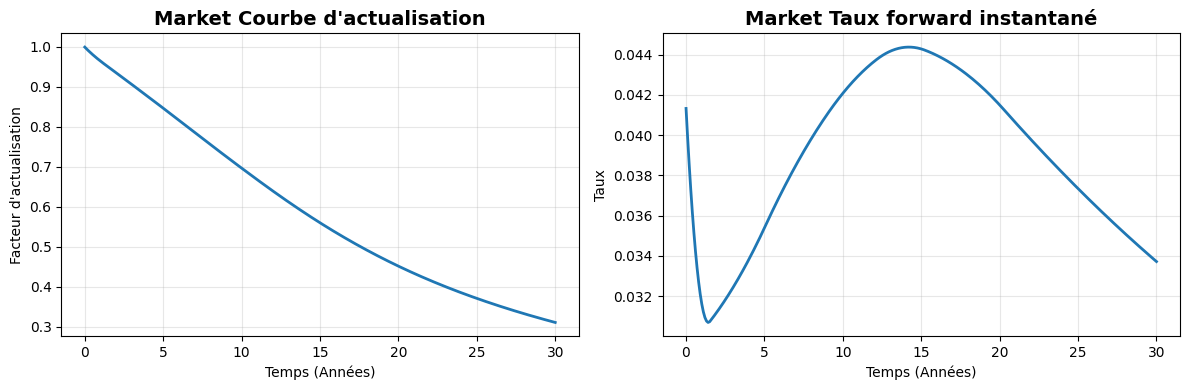

In [6]:
# -*- coding: utf-8 -*-
"""

Version "notebook-like" (linéaire, très simple) :
1) HW 1F : charger données -> curve -> pricer -> calibrer -> comparatif graphiques -> tracer PFE 
2) HW 2F : charger données -> curve -> pricer -> calibrer -> comparatif graphiques -> tracer PFE 
"""

from pathlib import Path
import sys
import numpy as np

# Lecture des fichiers Excel (courbe + template swaptions)
from ir.market.loaders_excel import load_curve_xlsx, load_swaption_template_xlsx

# Fonctions de plots "notebook-friendly" (affichage direct)
from ir.market.plots import plot_curve, plot_prices_by_tenor, plot_vols_by_tenor

# Outil pour impliciter une vol normale (Bachelier) à partir d'un prix (forward premium)
from ir.calibration.vol import black_normal_vol

# HW1F : pricer + calibrateur (a, sigma)
from ir.pricers.hw1f_pricer import HullWhitePricer
from ir.calibration.hw1f_calibration import HullWhiteCalibrator

# HW2F : pricer + calibrateur "profile" (outer: a,b,rho ; inner: sigma,eta)
from ir.pricers.hw2f_pricer import HullWhite2FPricer
from ir.calibration.hw2f_profile import HullWhite2FProfileCalibrator

# PFE : simulateur 2F et moteur d'exposition swap
from ir.risk.hw2f_sim import HW2FCurveSim
from ir.risk.pfe_swap import pfe_profile_swap
from ir.risk.pfe_plot import plot_pfe_profile


# ============================================================
# CONFIG 
# ============================================================
# Chemin du template Excel (contient une feuille "Curve" et une feuille "Template")
CURVE_XLSX = r"Calibration_Templates\SWPN_Calibration_Template_30092025_USD.xlsx"
TEMPLATE_XLSX = CURVE_XLSX

# Monte Carlo pour la partie PFE 
N_PATHS = 20000
SEED = 2025

# Paramètres de swap pour l'expo / PFE
PFE_TAU = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
PFE_NOTIONAL = 1_000_000.0
PFE_PAYER = True
PFE_Q = 0.95
PFE_GRID_N = 21


# ============================================================
# 2-3 mini helpers 
# ============================================================
def par_rate(curve, Tau):
    """
    Calcule :
    - A0 = annuité (somme des DF pondérés par les accruals)
    - S0 = taux swap par (par swap rate) à t=0
    pour un schedule Tau = [T0, T1, ..., Tn].
    """
    Tau = [float(x) for x in Tau]
    T0, Tn = Tau[0], Tau[-1]
    A0 = 0.0
    for i in range(1, len(Tau)):
        Ti = Tau[i]
        d = Tau[i] - Tau[i - 1]
        A0 += d * float(curve.discount(Ti))
    # S0 = (P(0,T0) - P(0,Tn)) / A0
    S0 = (float(curve.discount(T0)) - float(curve.discount(Tn))) / (A0 + 1e-18)
    return A0, S0  # annuity, par swap rate


def ensure_expiry_tenor(df, dates_col="Payment_Dates"):
    """
    Ajoute des colonnes "Expiry" et "Tenor" si elles n'existent pas déjà.
    - Expiry = première date de paiement (souvent = option expiry / swap start)
    - Tenor  = dernière - première (maturité du swap sous-jacent)
    """
    if "Expiry" not in df.columns:
        df["Expiry"] = df[dates_col].apply(lambda L: float(L[0]))
    if "Tenor" not in df.columns:
        df["Tenor"] = df[dates_col].apply(lambda L: float(L[-1]) - float(L[0]))


def add_implied_normal_vols_forward_premium(
    df,
    curve,
    price_col="Price",
    model_col="Model_Price",
    strike_col="Strike",
    dates_col="Payment_Dates",
):
    """
    Convertit les PRIX (ici: forward premium) en vols normales implicites (Bachelier),
    pour comparer Market vs Model en "vol space".

    Convention utilisée :
      forward premium = PV / DF(T0)
    donc on reconstruit l'annuité "forward" A_fwd = A0 / DF(T0).

    Attention :
    - strike_col est en % (ex: 2.5 signifie 2.5%)
    - forward_pct est aussi en % (on multiplie S0 par 100)
    """
    mkt_vol, mdl_vol = [], []
    for _, row in df.iterrows():
        Tau = row[dates_col]
        T0 = float(Tau[0])                 # expiry
        DF0 = float(curve.discount(T0))    # DF(0,T0)

        # quantités swap à t=0
        A0, S0 = par_rate(curve, Tau)

        # passage en "forward measure" (cohérent avec forward premium)
        annuity_fwd = A0 / (DF0 + 1e-18)

        strike_pct = float(row[strike_col])      # % (ATM typiquement)
        forward_pct = 100.0 * float(S0)          # % (S0 en units -> %)
        notional = float(row.get("Notional", 1.0))

        # prix market vs modèle (en forward premium si forward_premium=True)
        p_mkt = float(row[price_col])
        p_mdl = float(row[model_col])

        # inversion Bachelier : price -> sigma_N (en bps dans ton helper)
        mkt_vol.append(black_normal_vol(p_mkt, forward_pct, strike_pct, T0, notional, annuity_fwd))
        mdl_vol.append(black_normal_vol(p_mdl, forward_pct, strike_pct, T0, notional, annuity_fwd))

    df["Market_Vol (Bps)"] = mkt_vol
    df["Model_Vol (Bps)"] = mdl_vol


# ============================================================
# 1) LOAD DATA
# ============================================================
print("\n=== LOAD curve + swaptions template ===")

# Lecture de la courbe de discount (P(0,T)) depuis Excel
curve = load_curve_xlsx(CURVE_XLSX)

# Lecture du template de swaptions (expiries/tenors/strikes/prices)
swpn = load_swaption_template_xlsx(TEMPLATE_XLSX)

# Plot de sanity check : DF(t) + f(0,t)
plot_curve(curve, title_prefix="Market")


In [7]:
# ============================================================
# 2) HW 1F : pricer -> calibrate -> compare -> PFE
# ============================================================
print("\n" + "=" * 80)
print("HW 1F")
print("=" * 80)

print("[1F] initialisation pricer")
# On construit le pricer 1F à partir de la courbe.
# Le pricer embarque un curve_sim (HW1F) utilisé ensuite pour le PFE.
pricer_1f = HullWhitePricer(curve, n_paths=N_PATHS, seed=SEED)

print("[1F] calibrer (a,sigma) sur swaptions (forward premium)")
# On met le template sous forme de dict utilisable par le calibrateur
mkt_dict = swpn.to_market_dict()

# Calibrage de (a, sigma) sur les swaptions (prix en forward premium)
cal_1f = HullWhiteCalibrator(pricer_1f, mkt_dict, calibrate_to="Swaptions")

# Point de départ 
cal_1f.calibrate(init_a=0.01, init_sigma=0.01)



HW 1F
[1F] initialisation pricer
[1F] calibrer (a,sigma) sur swaptions (forward premium)
a: 0.010274, sigma: 0.007814, RMSRE: 9.36785e-02
a: 0.010158, sigma: 0.008699, RMSRE: 2.69424e-02
a: 0.010175, sigma: 0.008600, RMSRE: 2.40322e-02
a: 0.010184, sigma: 0.008594, RMSRE: 2.40012e-02
a: 0.010201, sigma: 0.008591, RMSRE: 2.39637e-02
a: 0.010309, sigma: 0.008588, RMSRE: 2.37790e-02
a: 0.010545, sigma: 0.008595, RMSRE: 2.34372e-02
a: 0.011086, sigma: 0.008630, RMSRE: 2.27746e-02
a: 0.011728, sigma: 0.008693, RMSRE: 2.20265e-02
a: 0.012130, sigma: 0.008762, RMSRE: 2.13929e-02
a: 0.012089, sigma: 0.008770, RMSRE: 2.13563e-02
a: 0.012091, sigma: 0.008770, RMSRE: 2.13562e-02

Calibration réussie :
Itérations : 12
Nombre d’instruments : 203
Erreur totale (RMSRE) :  +2.136%

Paramètres :
a optimal : 0.012091
sigma optimal : 0.008770

Swaption   0:  1.01Y à 9.01 Y | Modèle:   233.99 | Marché:   231.51 | Écart:  +1.071%
Swaption   1:  1.01Y à 8.01 Y | Modèle:   209.85 | Marché:   206.65 | Écart:

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.021356235677320333
        x: [-4.415e+00 -4.736e+00]
      nit: 12
      jac: [ 6.835e-08 -6.892e-06]
     nfev: 45
     njev: 15
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

[1F] compare market vs model (plots)


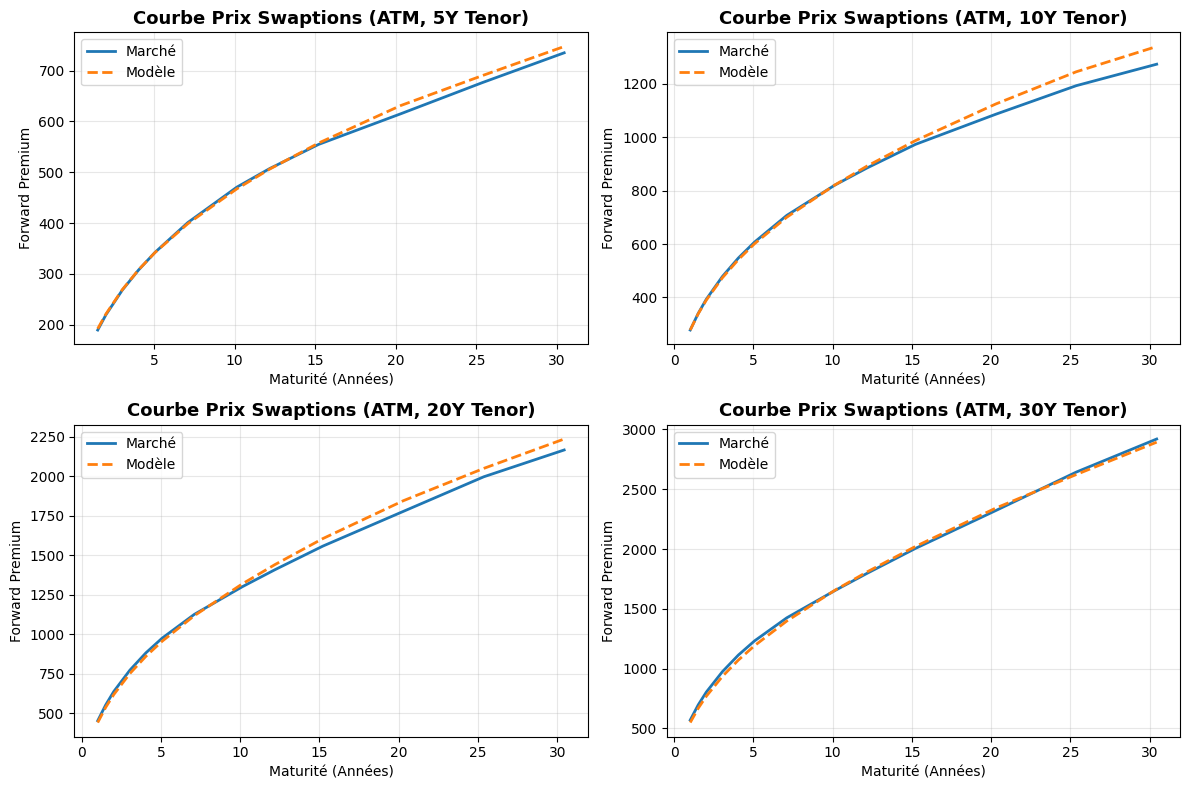

In [11]:
print("[1F] compare market vs model (plots)")

# Repricing du set de swaptions avec le modèle HW1F calibré
# forward_premium=True 
df_1f = swpn.with_model_prices_1f(pricer_1f, forward_premium=True)

# Ajout Expiry/Tenor
ensure_expiry_tenor(df_1f)

# Plot 2x2 : plusieurs tenors, prix en fonction de l'expiry
plot_prices_by_tenor(df_1f, mkt_col="Price", model_col="Model_Price", ylabel="Forward Premium", title= "Courbe Prix Swaptions"
)


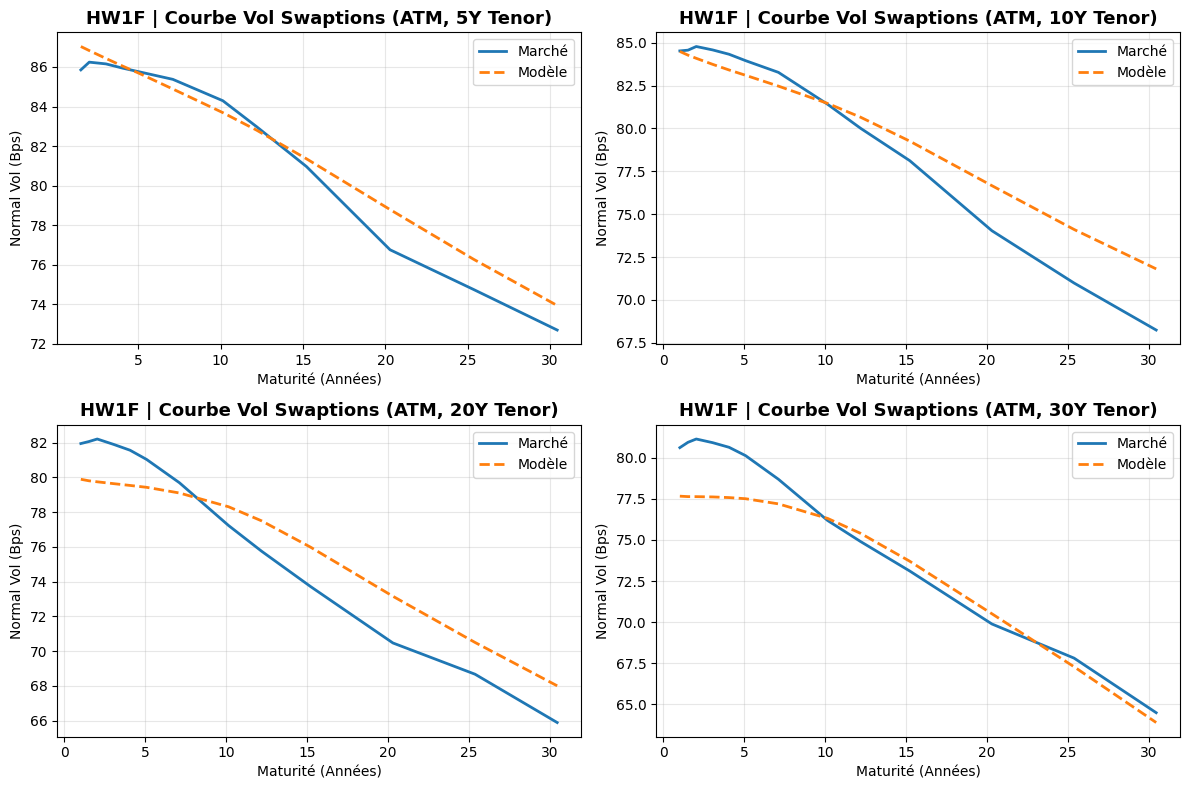

In [12]:
# Conversion des prix (forward premium) en vols normales implicites (Bachelier)
add_implied_normal_vols_forward_premium(df_1f, curve)

# Plot 2x2 des vols : "Market vol" vs "Model vol"
plot_vols_by_tenor(
    df_1f,
    mkt_col="Market_Vol (Bps)",
    model_col="Model_Vol (Bps)",
    ylabel="Normal Vol (Bps)",
    title="HW1F | Courbe Vol Swaptions",
)


In [14]:
print("[1F] PFE (swap)")

# Par rate du swap choisi 
A0, K_par = par_rate(curve, PFE_TAU)

# Grille temps où on calcule les exposures
grid = np.linspace(0.0, float(PFE_TAU[-1]), int(PFE_GRID_N))

# Calcul du profil PFE/EPE :
# - On simule P(t,Ti) via curve_sim (HW1F)
# - On reconstruit V(t) du swap sur chaque path
# - PFE = quantile de V+(t) ; EPE = moyenne de V+(t)
pfe_1f, epe_1f = pfe_profile_swap(
    curve_sim=pricer_1f.curve_sim,
    grid=grid,
    Tau=PFE_TAU,
    K=0.03,
    N=PFE_NOTIONAL,
    payer=PFE_PAYER,
    q=PFE_Q,
)


[1F] PFE (swap)


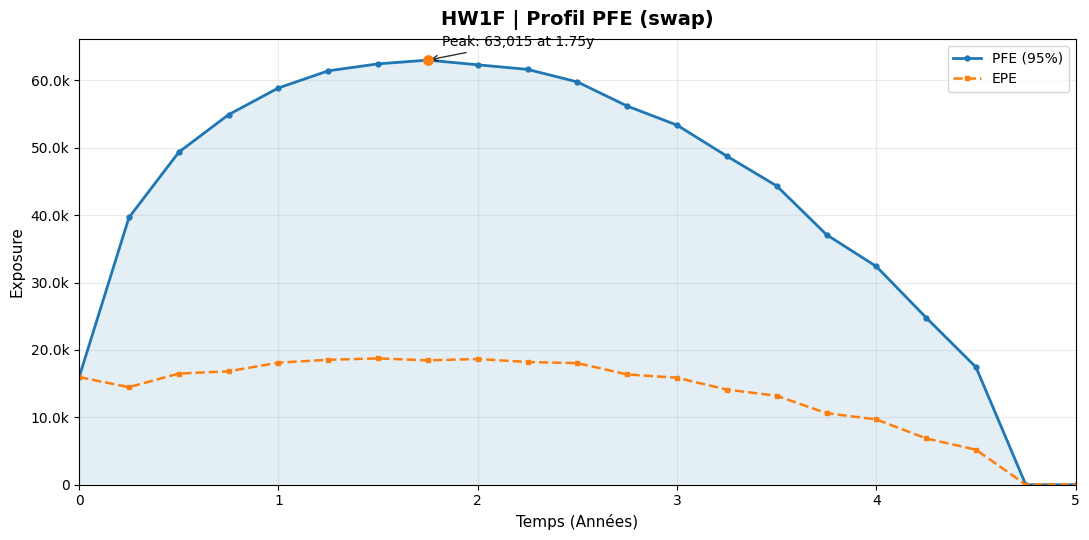

(<Figure size 1100x550 with 1 Axes>,
 <Axes: title={'center': 'HW1F | Profil PFE (swap)'}, xlabel='Temps (Années)', ylabel='Exposure'>)

In [15]:
# subtitle_1f = f"Tau={PFE_TAU} | N={PFE_NOTIONAL:,.0f} | K(par)={K_par*100:.3f}% | params={pricer_1f.model.parameters}"

# Plot propre du profil PFE/EPE
plot_pfe_profile(
    grid,
    pfe_1f,
    epe=epe_1f,
    q=PFE_Q,
    title="HW1F | Profil PFE (swap)",
)


In [16]:
# ============================================================
# 3) HW 2F : pricer -> calibrate -> compare -> PFE
# ============================================================
print("\n" + "=" * 80)
print("HW 2F (G2++)")
print("=" * 80)

print("[2F] initialisation du pricer")
# Pricer 2F : construit le modèle G2++ (a,b,rho,sigma,eta)
pricer_2f = HullWhite2FPricer(curve)

print("[2F] calibration profilé sur swaptions (forward premium)")
# Calibrage "profil" :
# - outer = (a,b,rho) via une grille (coarse search)
# - inner = (sigma,eta) via une optimisation locale (pour chaque candidat outer)
cal_2f = HullWhite2FProfileCalibrator(pricer_2f, mkt_dict, use_forward_premium=True)

# Grilles "petites" 
grid_a = [0.01, 0.02, 0.05, 0.10, 0.20]
grid_b = [0.001, 0.003, 0.01, 0.02, 0.05]
grid_rho = [-0.8, -0.5, -0.2, 0.0, 0.2]

cal_2f.calibrate_profile(
    grid_a=grid_a,
    grid_b=grid_b,
    grid_rho=grid_rho,
    init_sigma=0.01,
    init_eta=0.008,
    verbose_inner=False,   
    top_k=3,               
)



HW 2F (G2++)
[2F] initialisation du pricer
[2F] calibration profilé sur swaptions (forward premium)
Calibration profilé sur 203 swaptions.
Candidats grille externe : 95

[Outer 1/95] a=0.0100, b=0.0010, rho=-0.80
  -> inner best: sigma=0.012153, eta=0.004812, RMSRE=2.19278e-02

[Outer 2/95] a=0.0100, b=0.0010, rho=-0.50
  -> inner best: sigma=0.009460, eta=0.002168, RMSRE=2.75572e-02

[Outer 3/95] a=0.0100, b=0.0010, rho=-0.20
  -> inner best: sigma=0.008646, eta=0.000751, RMSRE=3.00067e-02

[Outer 4/95] a=0.0100, b=0.0010, rho=+0.00
  -> inner best: sigma=0.008518, eta=0.000100, RMSRE=3.04162e-02

[Outer 5/95] a=0.0100, b=0.0010, rho=+0.20
  -> inner best: sigma=0.008496, eta=0.000100, RMSRE=3.05235e-02

[Outer 6/95] a=0.0100, b=0.0030, rho=-0.80
  -> inner best: sigma=0.012419, eta=0.005375, RMSRE=2.28012e-02

[Outer 7/95] a=0.0100, b=0.0030, rho=-0.50
  -> inner best: sigma=0.009471, eta=0.002252, RMSRE=2.81540e-02

[Outer 8/95] a=0.0100, b=0.0030, rho=-0.20
  -> inner best: sigma=

{'best': {'a': 0.1,
  'b': 0.02,
  'rho': -0.8,
  'sigma': 0.0027553078403487435,
  'eta': 0.010575717621200999,
  'rmsre': 0.021276571479288898,
  'inner_result':   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    success: True
     status: 0
        fun: 0.021276571479288898
          x: [-5.894e+00 -4.549e+00]
        nit: 10
        jac: [ 8.108e-06 -5.288e-05]
       nfev: 60
       njev: 20
   hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>},
 'ranking': [{'a': 0.1,
   'b': 0.02,
   'rho': -0.8,
   'sigma': 0.0027553078403487435,
   'eta': 0.010575717621200999,
   'rmsre': 0.021276571479288898,
   'inner_result':   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
     success: True
      status: 0
         fun: 0.021276571479288898
           x: [-5.894e+00 -4.549e+00]
         nit: 10
         jac: [ 8.108e-06 -5.288e-05]
        nfev: 60
        njev: 20
    hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>},
  {'a': 0.05,
   'b': 0.02,
   'rho':

[2F] comparatif marché vs modèle (graphiques)


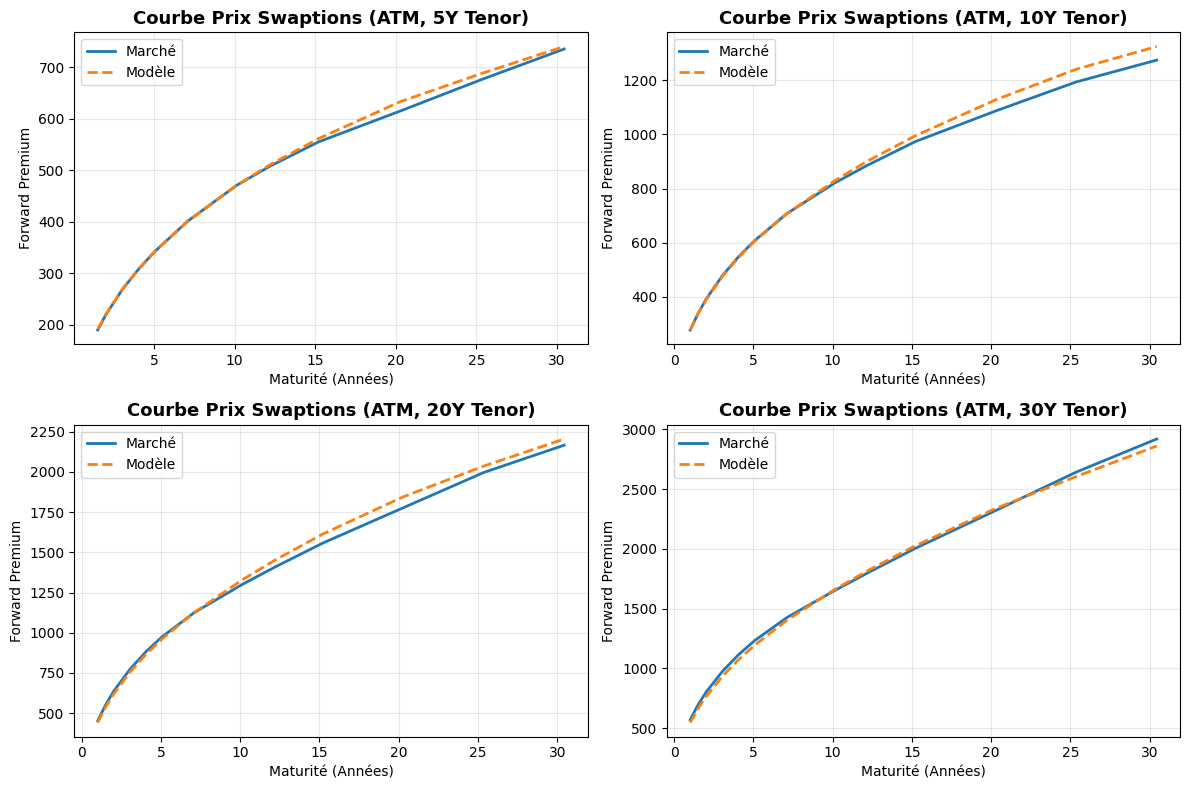

In [17]:
print("[2F] comparatif marché vs modèle (graphiques)")

# Repricing avec HW2F calibré
df_2f = swpn.with_model_prices_2f(pricer_2f, forward_premium=True)
ensure_expiry_tenor(df_2f)

plot_prices_by_tenor(df_2f, mkt_col="Price", model_col="Model_Price", ylabel="Forward Premium", title= "Courbe Prix Swaptions"
)


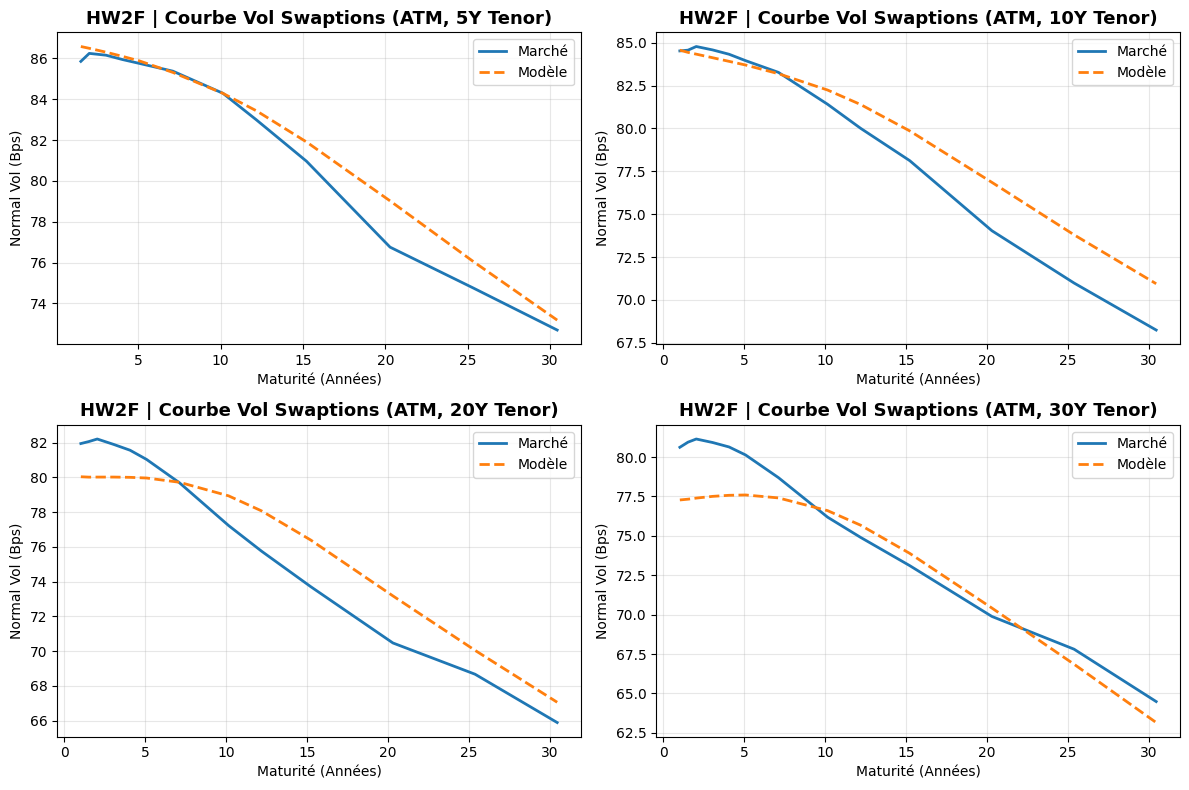

In [18]:
# Conversion en vols normales implicites (Bachelier)
add_implied_normal_vols_forward_premium(df_2f, curve)

plot_vols_by_tenor(
    df_2f,
    mkt_col="Market_Vol (Bps)",
    model_col="Model_Vol (Bps)",
    ylabel="Normal Vol (Bps)",
    title="HW2F | Courbe Vol Swaptions",
)


In [19]:
print("[2F] PFE (swap)")

# Simulateur 2F minimal : génère des distributions de P(t,T)
curve_sim_2f = HW2FCurveSim(
    curve=curve,
    model=pricer_2f.model,
    n_paths=N_PATHS,
    seed=SEED,
    use_legacy_global_seed=True,
)

# Même routine d'expo que pour 1F : seul le curve_sim change
pfe_2f, epe_2f = pfe_profile_swap(
    curve_sim=curve_sim_2f,
    grid=grid,
    Tau=PFE_TAU,
    K=0.03,
    N=PFE_NOTIONAL,
    payer=PFE_PAYER,
    q=PFE_Q,
)


[2F] PFE (swap)


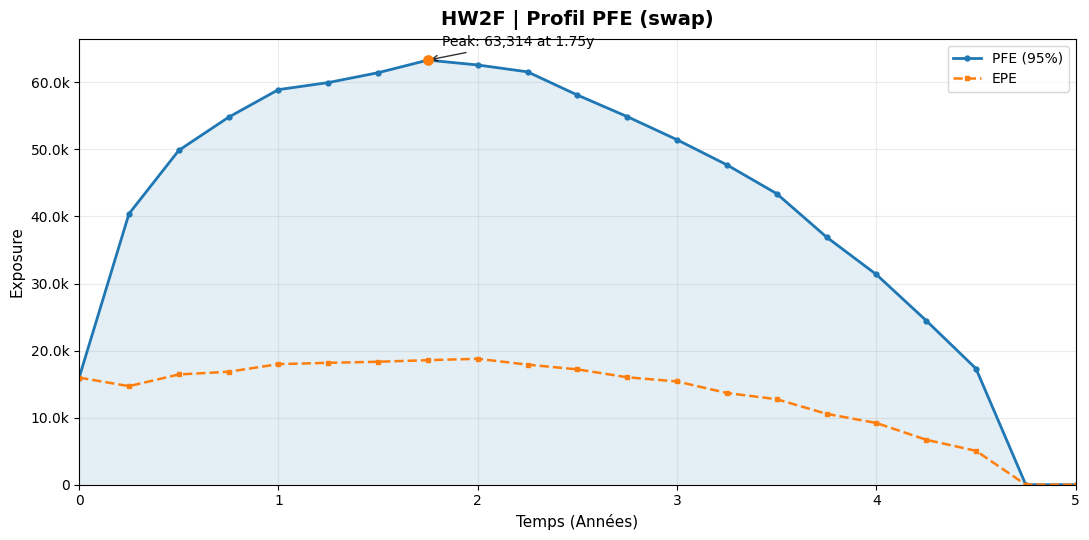

(<Figure size 1100x550 with 1 Axes>,
 <Axes: title={'center': 'HW2F | Profil PFE (swap)'}, xlabel='Temps (Années)', ylabel='Exposure'>)

In [20]:
# subtitle_2f = f"Tau={PFE_TAU} | N={PFE_NOTIONAL:,.0f} | K(par)={K_par*100:.3f}% | params={pricer_2f.model.parameters}"

plot_pfe_profile(
    grid,
    pfe_2f,
    epe=epe_2f,
    q=PFE_Q,
    title="HW2F | Profil PFE (swap)",
)
